In [14]:
import numpy as np
import random
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
from deap import base, creator, tools, algorithms
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [16]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [17]:
all_features = np.load('all_features_vgg16.npy')
all_labels = np.load('all_labels_vgg16.npy')



In [18]:
all_features

array([[-0.01595471, -0.02323486, -0.03968799, ..., -0.0262275 ,
        -0.0721586 , -0.04747448],
       [-0.01595471, -0.02323486, -0.03968799, ..., -0.0262275 ,
        -0.11433829, -0.04747448],
       [-0.01595471, -0.02323486, -0.03968799, ..., -0.0262275 ,
        -0.59788954, -0.04747448],
       ...,
       [-0.01595471, -0.02323486, -0.03968799, ..., -0.0262275 ,
        -0.37254465, -0.04747448],
       [-0.01595471, -0.02323486, -0.03968799, ..., -0.0262275 ,
        -0.59788954, -0.04747448],
       [-0.01595471, -0.02323486, -0.03968799, ..., -0.0262275 ,
        -0.10403824, -0.04747448]], dtype=float32)

In [19]:
all_labels

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test, y_train, y_test = train_test_split( all_features, all_labels, test_size=0.2, random_state=42 )

In [21]:
num_classes=4

In [22]:
y_train

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [23]:
y_test

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [24]:
def evaluate_model(individual):
    num_layers = int(individual[0])  
    neurons_per_layer = individual[1]
    dropout_rate = individual[2]

    # Create the model
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(x_train.shape[1],)))

    for _ in range(num_layers):
        model.add(layers.Dense(neurons_per_layer, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(4, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=0, callbacks=[early_stopping])

    # Evaluate the model
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return accuracy,  

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("num_layers", lambda: random.choice([2, 4, 8, 16]))  
toolbox.register("neurons_per_layer", lambda: random.choice([128, 256, 512, 1024]))  
toolbox.register("dropout_rate", lambda: random.choice([0.2, 0.4]))  

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.num_layers, toolbox.neurons_per_layer, toolbox.dropout_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_model)
toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutPolynomialBounded, low=[1, 32, 0.0], up=[5, 512, 1.0], eta=1.0, indpb=0.2)

toolbox.register("select", tools.selTournament, tournsize=3)


/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [26]:
population = toolbox.population(n=10)  
NGEN = 10 
CXPB, MUTPB = 0.5, 0.2  

best_accuracy = 0 
best_model = None  

for gen in range(NGEN):
    print(f"Generation {gen+1}")
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = toolbox.select(offspring, len(population))

    best_ind = tools.selBest(population, 1)[0]
    current_accuracy = best_ind.fitness.values[0]

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        num_layers = int(best_ind[0])
        neurons_per_layer = best_ind[1]
        dropout_rate = best_ind[2]

        best_model = models.Sequential()
        best_model.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
        for _ in range(num_layers):
            best_model.add(layers.Dense(neurons_per_layer, activation='relu'))
            best_model.add(layers.Dropout(dropout_rate))

        best_model.add(layers.Dense(4, activation='softmax'))

        # Compile the model
        best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Print the best individual
print(f"Best individual: {best_ind}")
print(f"Best fitness: {best_ind.fitness.values[0]}")

Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Best individual: [5, 256, 0.12313061786995233]
Best fitness: 0.8696629405021667


In [27]:
num_layers = int(round(best_ind[0])) 
neurons_per_layer = int(best_ind[1])  
dropout_rate = best_ind[2]




print(f"Rounded Parameters: Layers = {num_layers}, Neurons per Layer = {neurons_per_layer}, Dropout Rate = {dropout_rate}")

model = models.Sequential()

model.add(layers.InputLayer(input_shape=(x_train.shape[1],))) 

for _ in range(num_layers):
    model.add(layers.Dense(neurons_per_layer, activation='relu'))
    model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Rounded Parameters: Layers = 5, Neurons per Layer = 256, Dropout Rate = 0.12313061786995233
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_877 (Dense)           (None, 256)               6422784   
                                                                 
 dropout_792 (Dropout)       (None, 256)               0         
                                                                 
 dense_878 (Dense)           (None, 256)               65792     
                                                                 
 dropout_793 (Dropout)       (None, 256)               0         
                                                                 
 dense_879 (Dense)           (None, 256)               65792     
                                                                 
 dropout_794 (Dropout)       (None, 256)               0         
                           

In [28]:
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32,validation_data=[x_train, y_train])



Epoch 1/50
167/167 [==============================] - 2s 10ms/step - loss: 1.2719 - accuracy: 0.5818 - val_loss: 0.5149 - val_accuracy: 0.8272
Epoch 2/50
167/167 [==============================] - 2s 10ms/step - loss: 0.5623 - accuracy: 0.8299 - val_loss: 0.1792 - val_accuracy: 0.9464
Epoch 3/50
167/167 [==============================] - 2s 10ms/step - loss: 0.2665 - accuracy: 0.9331 - val_loss: 0.1316 - val_accuracy: 0.9657
Epoch 4/50
167/167 [==============================] - 2s 10ms/step - loss: 0.2277 - accuracy: 0.9552 - val_loss: 0.0980 - val_accuracy: 0.9788
Epoch 5/50
167/167 [==============================] - 2s 10ms/step - loss: 0.2277 - accuracy: 0.9651 - val_loss: 0.1005 - val_accuracy: 0.9736
Epoch 6/50
167/167 [==============================] - 2s 10ms/step - loss: 0.1419 - accuracy: 0.9728 - val_loss: 0.1024 - val_accuracy: 0.9876
Epoch 7/50
167/167 [==============================] - 2s 10ms/step - loss: 0.1307 - accuracy: 0.9770 - val_loss: 0.0738 - val_accuracy: 0.9888

In [29]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Print out the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

42/42 [==============================] - 0s 3ms/step - loss: 5.1379 - accuracy: 0.8936
Test Loss: 5.137920379638672
Test Accuracy: 0.8936329483985901


In [30]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1)  

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes)
print(report)


42/42 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       197
           1       0.34      0.72      0.46        18
           2       0.92      0.93      0.93       645
           3       0.93      0.86      0.89       475

    accuracy                           0.89      1335
   macro avg       0.76      0.85      0.78      1335
weighted avg       0.90      0.89      0.90      1335



In [31]:
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)  
y_test_classes = np.argmax(y_test, axis=1)  

report = classification_report(y_test_classes, y_pred_classes)
print(report)

42/42 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       197
           1       0.34      0.72      0.46        18
           2       0.92      0.93      0.93       645
           3       0.93      0.86      0.89       475

    accuracy                           0.89      1335
   macro avg       0.76      0.85      0.78      1335
weighted avg       0.90      0.89      0.90      1335



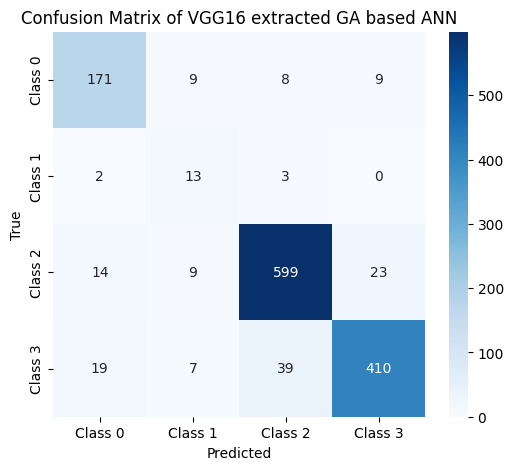

In [32]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix of VGG16 extracted GA based ANN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

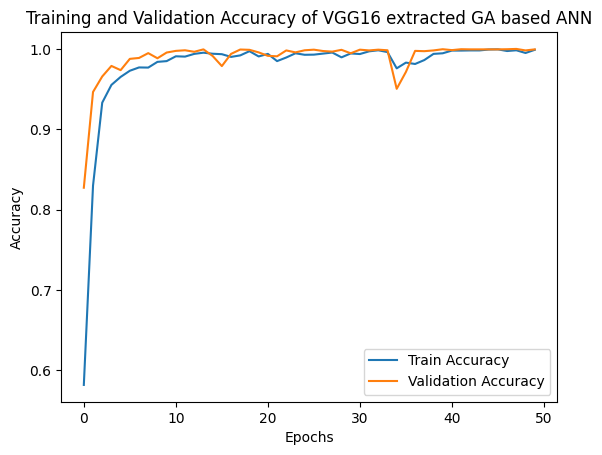

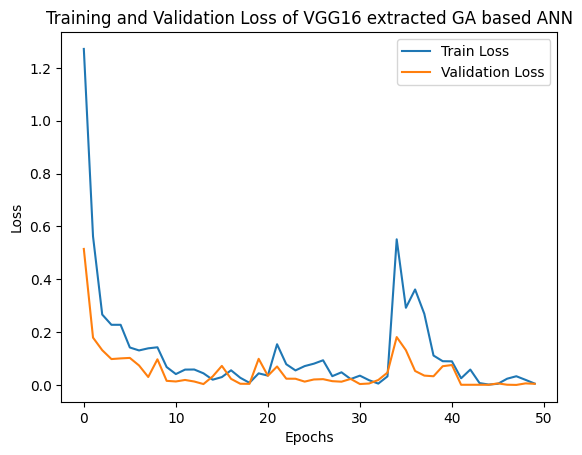

In [33]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16 extracted GA based ANN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of VGG16 extracted GA based ANN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [34]:
model.save("best_vgg16.h5")

/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
